In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import public modules
import re
import scipy
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import custom modules
from applications.molecules.src import utils
from applications.molecules.src import cheminf
from applications.molecules.src import plotting

# Use latex-like font for figures
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family']      = 'STIXGeneral'

# Generate the figures directory if it does not exist yet
figures_dir_path = '../figures/'
utils.create_folder_if_inexistent(figures_dir_path)

[17:10:41] Initializing Normalizer


In [3]:
#######################################################################################################################
### Define global plot specs
#######################################################################################################################
color_uc           = 'tan'                                         # Unconditional
color_cn           = 'navy'                                        # Conditional (exact) for  Number of rings predictor
color_cp           = 'indianred'                                   # Conditional (exact) for LogP predictor
color_d            = 'teal'                                        # Data
color_ce           = 'orange'                                      # Conditional (???)
label_uc           = r'$p^{\theta}(x)$'                            # Unconditional
label_cn           = r'$p^{\theta}(x\,|\,N_{r}^{\star})$'           # Conditional (exact) for  Number of rings predictor
label_cp           = r'$p^{\theta}(x\,|\,\mathrm{LogP}^{\star})$'   # Conditional (exact) for LogP predictor
x_label_num_rings  = r'$N_{r}$'                           
x_label_logp       = r'$\mathrm{LogP}$'
x_label_ts         = 'Tanimoto similarity'
x_ticks_ts         = [0, 0.25, 0.5, 0.75, 1]
x_tick_labels_ts   = ['0', '0.25', '0.5', '0.75', '1']
alpha              = 0.7
color_ca           = color_cn                                      # Conditional (approximated)
color_ce           = 'darkorange'                                  # Conditional (exact)
label_ca           = 'Approximate'                                 # Conditional (approximated)
label_ce           = 'Exact'                                       # Conditional (exact)

# Define Morgan fingerprint settings (used for pairwise Tanimoto similarity determination)
mfp_radius = 2
mfp_size   = int(2**10)
# Which Tanimoto similarity to determine per molecule (if 'average', the average Tanimoto similarity to all other molecules will be determined)
which_ts   = 'average'

# Determine the bin-edges for the Tanimoto similarities histograms
bin_centers_ts = np.linspace(0, 1, 101)
bin_width_ts   = np.mean(np.diff(bin_centers_ts))
bin_edges_ts   = np.hstack([bin_centers_ts[0]-bin_width_ts/2, bin_centers_ts+bin_width_ts/2])

In [4]:
######################################################################################################
### Load the generated molecules for different target properties as different DataFrames
######################################################################################################
# Define the generated directory
generated_dir = '../generated/article'

# Define the name of the samples table files
samples_table_name = 'samples_table.tsv'

# Define a dictionary with all the different directory paths 
# relative to the generation directory
rel_dir_path_dict = {
    # Number of rings (unconditional)
    'num_rings=None':    'num_rings=None|n=1000',

    # Number of rings (exact sampling)
    'num_rings=0_exact': 'num_rings=0|n=1000',
    'num_rings=1_exact': 'num_rings=1|n=1000',
    'num_rings=2_exact': 'num_rings=2|n=1000',
    'num_rings=3_exact': 'num_rings=3|n=1000',
    'num_rings=4_exact': 'num_rings=4|n=1000',
    'num_rings=5_exact': 'num_rings=5|n=1000',
    'num_rings=6_exact': 'num_rings=6|n=1000',
    'num_rings=7_exact': 'num_rings=7|n=1000',

    # Number or rings (TAG)
    'num_rings=0_TAG':   'num_rings=0|n=1000|sampler.grad_approx=True',
    'num_rings=1_TAG':   'num_rings=1|n=1000|sampler.grad_approx=True',
    'num_rings=2_TAG':   'num_rings=2|n=1000|sampler.grad_approx=True',
    'num_rings=3_TAG':   'num_rings=3|n=1000|sampler.grad_approx=True',
    'num_rings=4_TAG':   'num_rings=4|n=1000|sampler.grad_approx=True',
    'num_rings=5_TAG':   'num_rings=5|n=1000|sampler.grad_approx=True',
    'num_rings=6_TAG':   'num_rings=6|n=1000|sampler.grad_approx=True',
    'num_rings=7_TAG':   'num_rings=7|n=1000|sampler.grad_approx=True',
    
    # LogP (unconditional)
    'logp=None':     'logp=None|n=1000',

    # LogP (exact sampling)
    'logp=-2_exact': 'logp=-2|n=1000',
    'logp=0_exact':  'logp=0|n=1000',
    'logp=2_exact':  'logp=2|n=1000',
    'logp=4_exact':  'logp=4|n=1000',
    'logp=6_exact':  'logp=6|n=1000',
    'logp=8_exact':  'logp=8|n=1000',
    'logp=10_exact': 'logp=10|n=1000',

    # LogP (TAG)
    'logp=-2_TAG':   'logp=-2|n=1000|sampler.grad_approx=True',
    'logp=0_TAG':    'logp=0|n=1000|sampler.grad_approx=True',
    'logp=2_TAG':    'logp=2|n=1000|sampler.grad_approx=True',
    'logp=4_TAG':    'logp=4|n=1000|sampler.grad_approx=True',
    'logp=6_TAG':    'logp=6|n=1000|sampler.grad_approx=True',
    'logp=8_TAG':    'logp=8|n=1000|sampler.grad_approx=True',
    'logp=10_TAG':   'logp=10|n=1000|sampler.grad_approx=True',
}

# Load all the dataframes containing the sampled/generated tables
gen_df_dict = dict()
for key, rel_dir_path in rel_dir_path_dict.items():
    file_path = str(Path(generated_dir, rel_dir_path, samples_table_name))
    gen_df_dict[key] = pd.read_csv(file_path, sep='\t')


target_num_rings=nan
Number of smiles (after filter): 997
#unique_valid-smiles:            997
#unique-valid_molecules:         997
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------
target_num_rings=0
Number of smiles (after filter): 918
#unique_valid-smiles:            918
#unique-valid_molecules:         916
#uniqueness-fraction:            0.998
----------------------------------------------------------------------------------------------------
****************************************************************************************************
Mean Tanimoto similarity 'num_rings=None': 0.11682931619165803
Mean Tanimoto similarity num_rings=0_exact: 0.17379894105464416
****************************************************************************************************
target_num_rings=nan
Number of smiles (after filter): 997
#unique_valid-smiles:            997
#unique-valid_molecules:         9

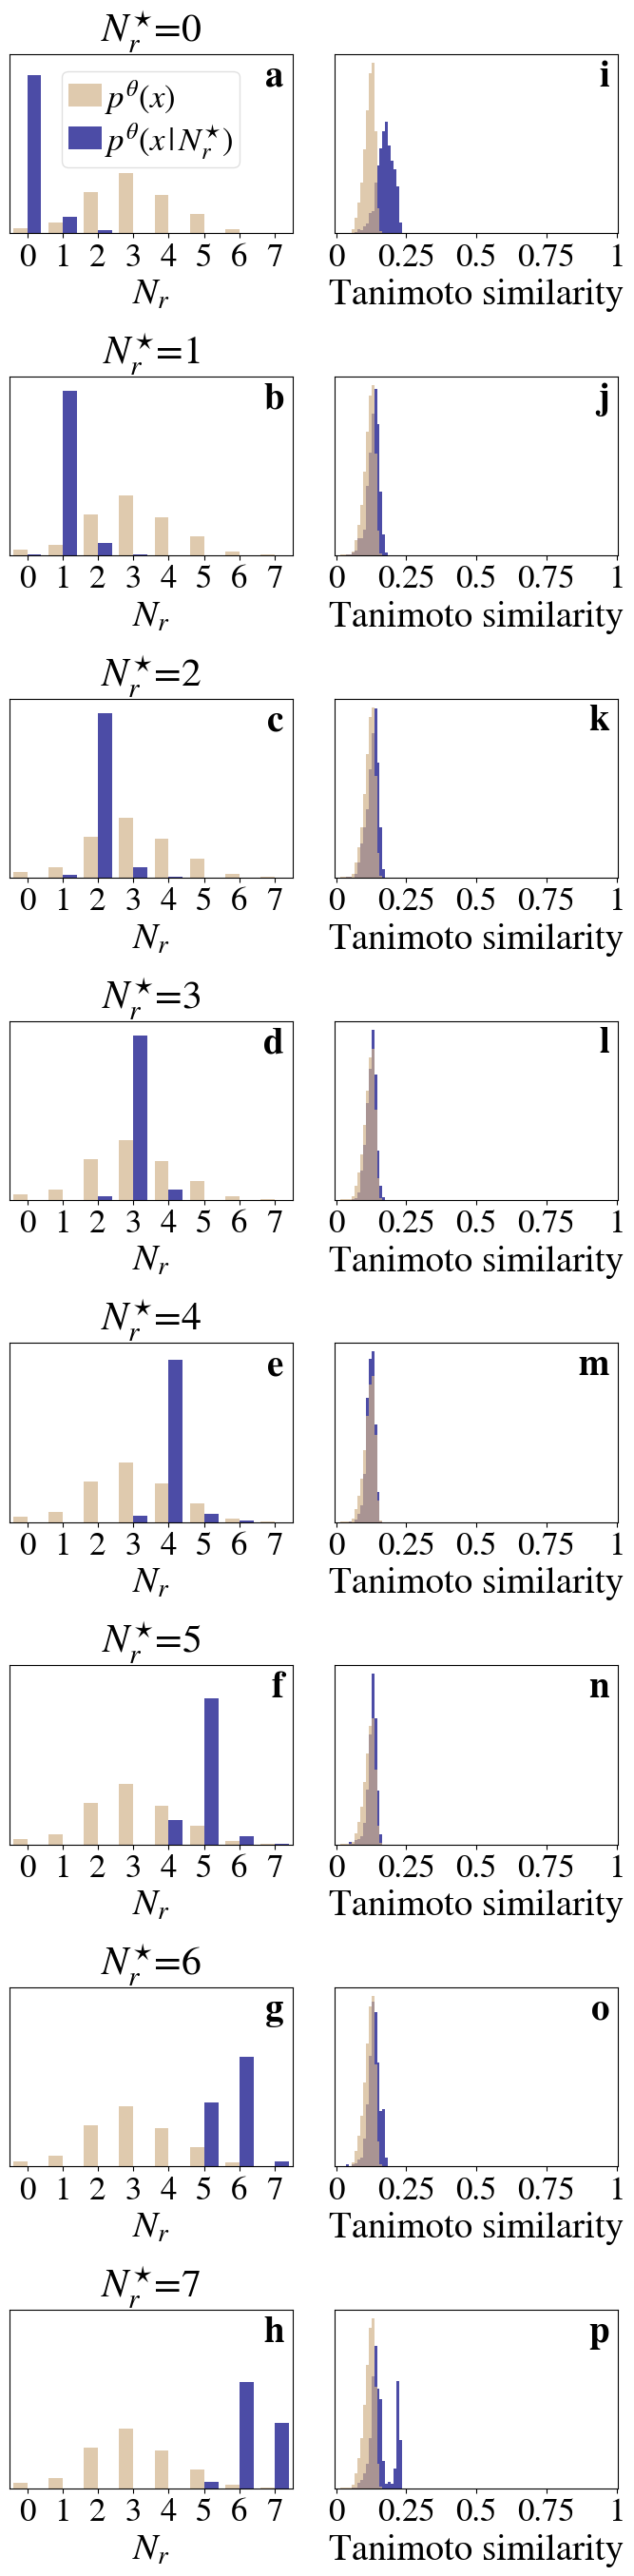

----------------------------------------------------------------------------------------------------
target_num_rings=0
Number of smiles (after filter): 918
#unique_valid-smiles:            918
#unique-valid_molecules:         916
#uniqueness-fraction:            0.998
----------------------------------------------------------------------------------------------------


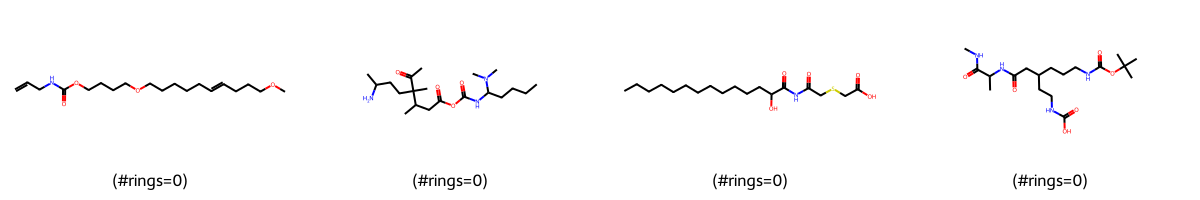

----------------------------------------------------------------------------------------------------
target_num_rings=1
Number of smiles (after filter): 989
#unique_valid-smiles:            989
#unique-valid_molecules:         989
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


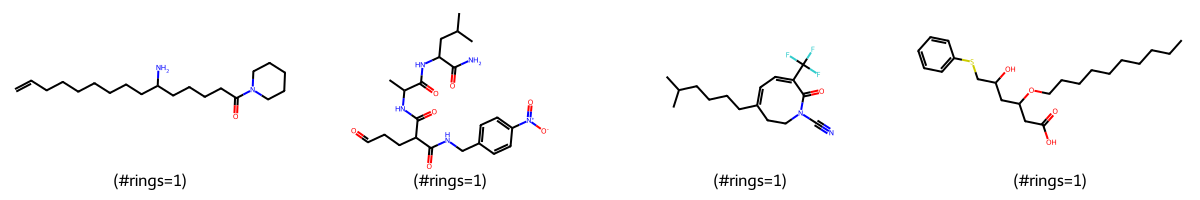

----------------------------------------------------------------------------------------------------
target_num_rings=2
Number of smiles (after filter): 989
#unique_valid-smiles:            989
#unique-valid_molecules:         988
#uniqueness-fraction:            0.999
----------------------------------------------------------------------------------------------------


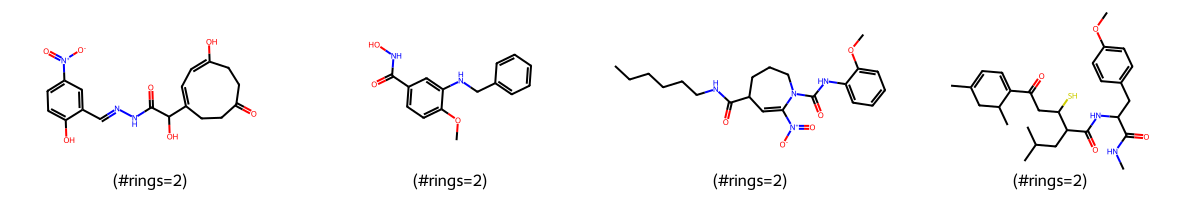

----------------------------------------------------------------------------------------------------
target_num_rings=3
Number of smiles (after filter): 994
#unique_valid-smiles:            994
#unique-valid_molecules:         994
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


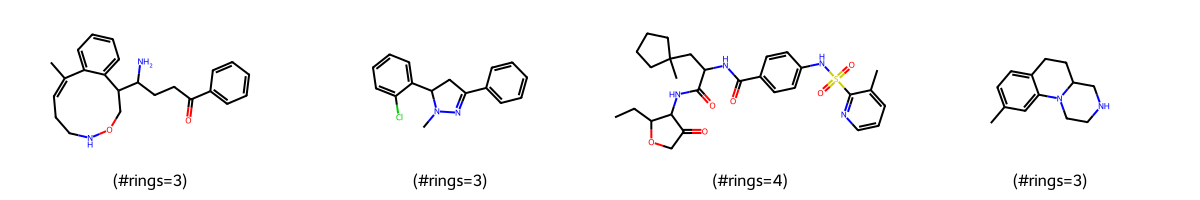

----------------------------------------------------------------------------------------------------
target_num_rings=4
Number of smiles (after filter): 981
#unique_valid-smiles:            981
#unique-valid_molecules:         981
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


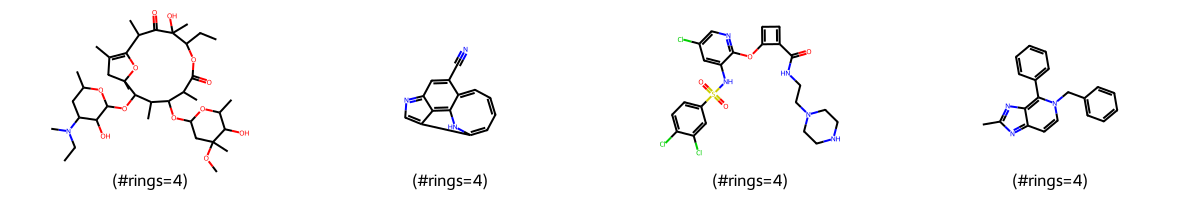

----------------------------------------------------------------------------------------------------
target_num_rings=5
Number of smiles (after filter): 941
#unique_valid-smiles:            941
#unique-valid_molecules:         941
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


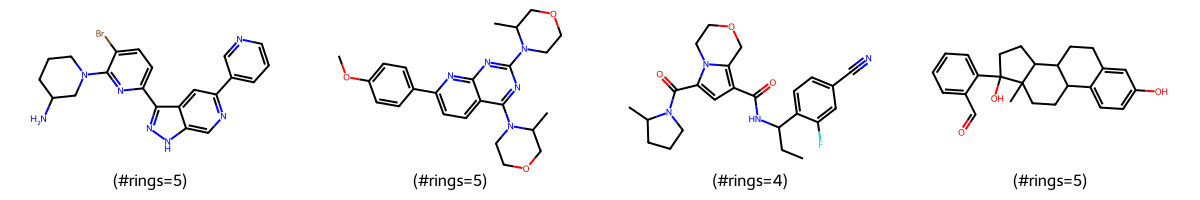

----------------------------------------------------------------------------------------------------
target_num_rings=6
Number of smiles (after filter): 862
#unique_valid-smiles:            862
#unique-valid_molecules:         862
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


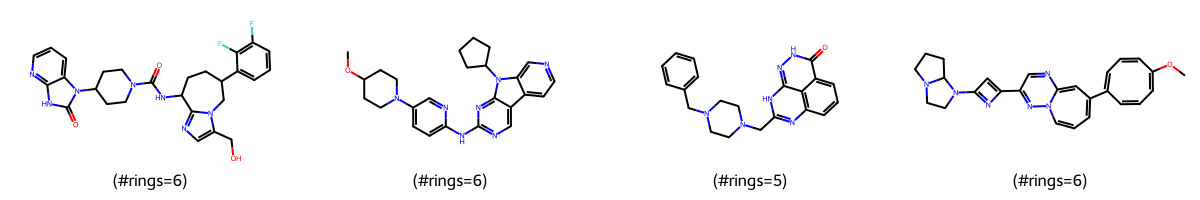

----------------------------------------------------------------------------------------------------
target_num_rings=7
Number of smiles (after filter): 638
#unique_valid-smiles:            638
#unique-valid_molecules:         636
#uniqueness-fraction:            0.997
----------------------------------------------------------------------------------------------------


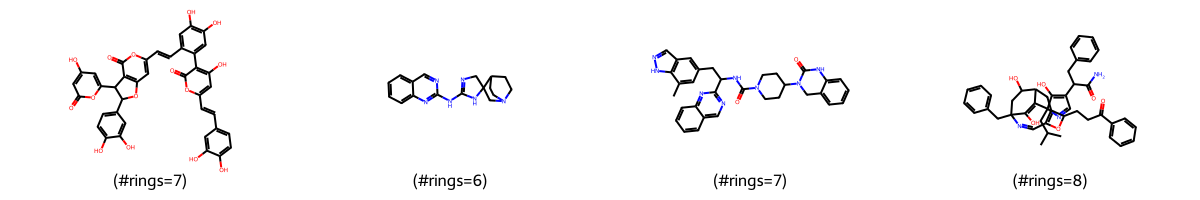

In [5]:
##############################################################################################################
### 1) Figure displaying property distribution for molecules generated for different target num_rings values
##############################################################################################################
# Define local plot specs
bin_centers_num_rings        = np.linspace(0, 7, 8)
panel_label_rel_xy_num_rings = [0.97, 0.97]
panel_label_rel_xy_ts        = [0.97, 0.97]
num_valid_samples_num_rings  = 1000
fs_dict  = {
    'axis':  28, #25,
    'ticks': 25, #22,
    'leg':   25, #22,
    'title': 30, #27,
    'text':  28, #25,
}
exact_or_tag        = 'exact' # Show 'exact' or 'tag'?
num_rings_list      = ['num_rings=0', 'num_rings=1', 'num_rings=2', 'num_rings=3', 'num_rings=4', 'num_rings=5', 'num_rings=6', 'num_rings=7'] #'num_rings=3' 'num_rings=4'
panel_labels        = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's']
panel_counter_col0  = 0
panel_counter_col1  = 0
num_rows            = len(num_rings_list)

# Make the figure and with panels
fig, axs = plt.subplots(num_rows, 2, figsize=(4*2, len(num_rings_list)*4))

### Row 1, col 1/2: Number of rings
for index, key in enumerate(num_rings_list):
    # Update the key
    key = f"{key}_{exact_or_tag}"

    ## Get the first column axis
    ax = axs[index, 0]

    # Only show legend for first plot
    if index==0:
        show_legend=True
    else:
        show_legend=False

    # Get the panel label
    panel_label         = panel_labels[panel_counter_col0]
    panel_counter_col0 += 1

    # Get the current target class
    target_num_rings = int(list(set(gen_df_dict[key]['target_num_rings']))[0])

    # Set a title
    title_label = r'$N_{r}^{\star}$='+str(target_num_rings)
    ax.set_title(title_label, fontsize=fs_dict['title'])

    # Get the property (here num-rings) distribution for the valid molecules
    distr_l = utils.get_property_distr(gen_df_dict['num_rings=None'], 'ground_truth', property_name='num_rings', num_valid_samples=num_valid_samples_num_rings)
    distr_r = utils.get_property_distr(gen_df_dict[key], 'ground_truth', property_name='num_rings', num_valid_samples=num_valid_samples_num_rings)

    # Make the plot
    plotting.plot_num_rings_distr(distr_l,
                                  distr_r, 
                                  bin_centers=bin_centers_num_rings,
                                  color_l=color_uc,
                                  color_r=color_cn,
                                  label_l=label_uc,
                                  label_r=label_cn,
                                  x_label=x_label_num_rings,
                                  show_y_ticks=False,
                                  show_legend=show_legend,
                                  fs_dict=fs_dict,
                                  panel_label=panel_label,
                                  panel_label_rel_xy=panel_label_rel_xy_num_rings,
                                  panel_label_ha='right',
                                  panel_label_fontweight='bold',
                                  ax=ax,
                                  leg_loc='upper center',
                                  leg_framealpha=0.6,
                                  leg_borderpad=0.2,
                                  leg_handletextpad=0.1,
                                  leg_handlelength=1,
                                  leg_vertical_labelspacing=0.1,
                                  alpha=alpha)

    ## Get the second column axis
    ax = axs[index, 1]

    # Get the panel label
    panel_label         = panel_labels[num_rows+panel_counter_col1]
    panel_counter_col1 += 1

    # Get the pairwise Tanimoto similarity (ts) distribution
    ts_distr_l = cheminf.get_tanimoto_similarities(gen_df_dict['num_rings=None']['nswcs'], which=which_ts, mfp_radius=mfp_radius, mfp_size=mfp_size)
    ts_distr_r = cheminf.get_tanimoto_similarities(gen_df_dict[key]['nswcs'], which=which_ts, mfp_radius=mfp_radius, mfp_size=mfp_size)
    print('*'*100)
    print(f"Mean Tanimoto similarity 'num_rings=None': {np.mean(ts_distr_l)}")
    print(f"Mean Tanimoto similarity {key}: {np.mean(ts_distr_r)}")
    print('*'*100)

    # Make the plot
    plotting.plot_tanimoto_similarity_distr(ts_distr_l,
                                            ts_distr_r, 
                                            bin_edges=bin_edges_ts,
                                            color_l=color_uc,
                                            color_r=color_cn,
                                            label_l=label_uc,
                                            label_r=label_cn,
                                            x_label=x_label_ts,
                                            x_ticks=x_ticks_ts,
                                            x_tick_labels=x_tick_labels_ts,
                                            show_y_ticks=False,
                                            show_legend=False,
                                            fs_dict=fs_dict,
                                            panel_label=panel_label,
                                            panel_label_rel_xy=panel_label_rel_xy_ts,
                                            panel_label_ha='right',
                                            panel_label_fontweight='bold',
                                            ax=ax,
                                            alpha=alpha)


### Global specs
# Adjust subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.15, #0.08, 
                    hspace=0.8) #0.7

plt.show()

# Save the figure as pdf
file_path = str(Path(figures_dir_path, 'appendix_num_rings_guidance.pdf'))
fig.savefig(file_path, format='pdf', bbox_inches='tight')


####################################################################################################
### Display the first 4 molecules generated for each specified target num_rings value
####################################################################################################
show_first = 4
property_name = 'num_rings'
property_label = '#rings'
subImgSize = (300, 200)
for key in num_rings_list:
    # Update the key
    key = f"{key}_{exact_or_tag}"
    
    print('-'*100)
    filtered_df = utils.filter_unique_valid(gen_df_dict[key], show_first)
    nswcs_list = filtered_df['nswcs']
    img = cheminf.draw_molecule_grid(nswcs_list[:show_first], 
                                     property_name=property_name, 
                                     property_label=property_label, 
                                     molsPerRow=show_first, 
                                     subImgSize=subImgSize)
    display(img)



target_logp=nan
Number of smiles (after filter): 997
#unique_valid-smiles:            997
#unique-valid_molecules:         997
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------
target_logp=-2
Number of smiles (after filter): 816
#unique_valid-smiles:            816
#unique-valid_molecules:         814
#uniqueness-fraction:            0.998
----------------------------------------------------------------------------------------------------
****************************************************************************************************
Mean Tanimoto similarity 'logp=None': 0.11682931619165803
Mean Tanimoto similarity logp=-2_exact: 0.13722436405334115
****************************************************************************************************
target_logp=nan
Number of smiles (after filter): 997
#unique_valid-smiles:            997
#unique-valid_molecules:         997
#uniqueness-fraction

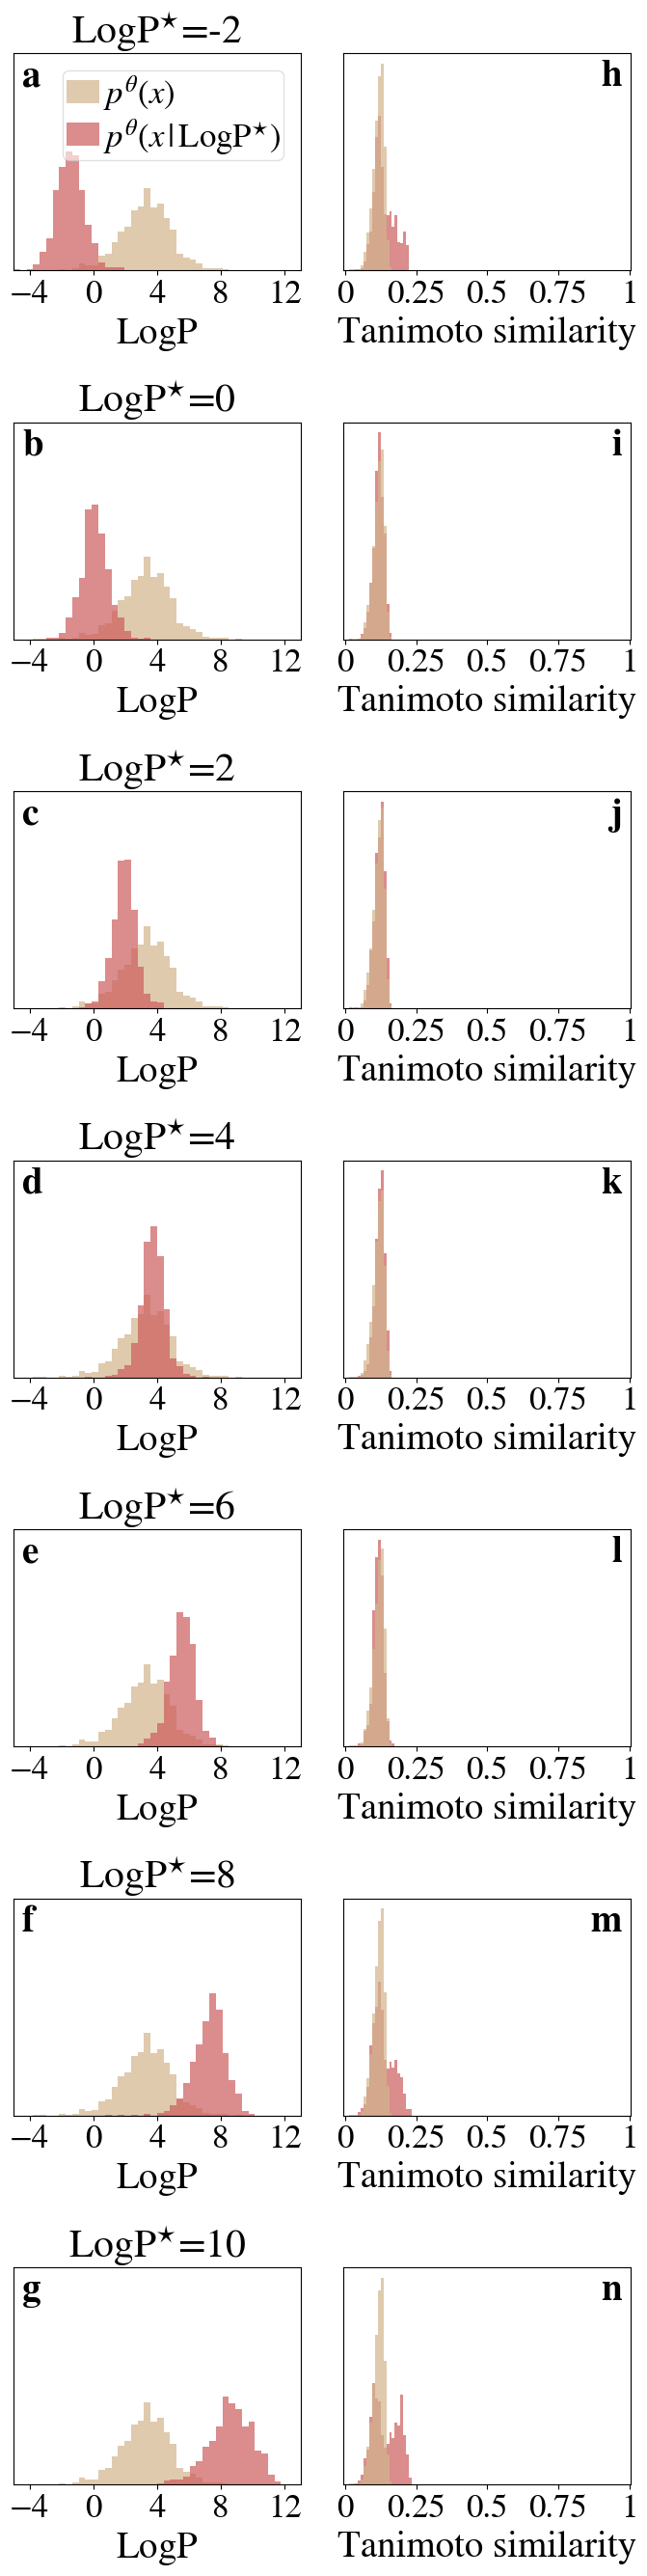

----------------------------------------------------------------------------------------------------
target_logp=-2
Number of smiles (after filter): 816
#unique_valid-smiles:            816
#unique-valid_molecules:         814
#uniqueness-fraction:            0.998
----------------------------------------------------------------------------------------------------


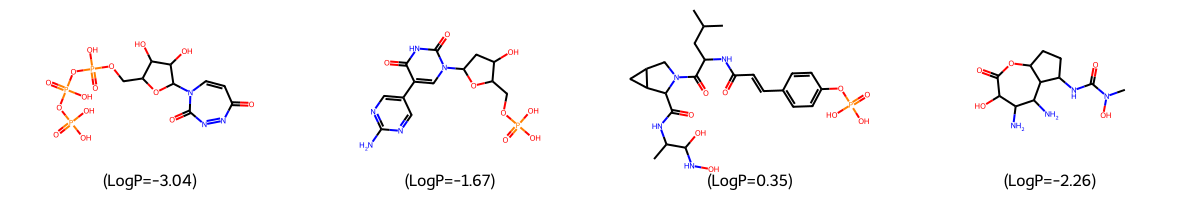

----------------------------------------------------------------------------------------------------
target_logp=0
Number of smiles (after filter): 956
#unique_valid-smiles:            956
#unique-valid_molecules:         956
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


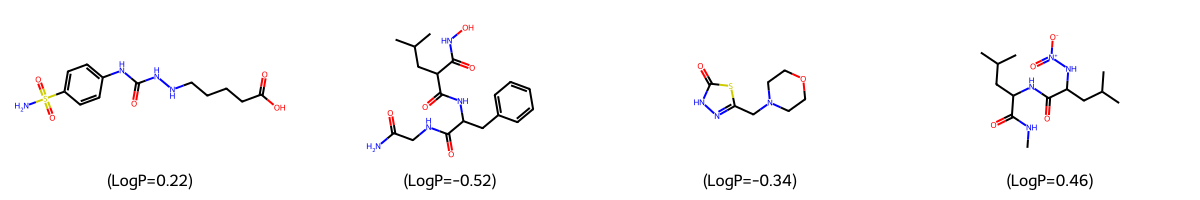

----------------------------------------------------------------------------------------------------
target_logp=2
Number of smiles (after filter): 992
#unique_valid-smiles:            992
#unique-valid_molecules:         992
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


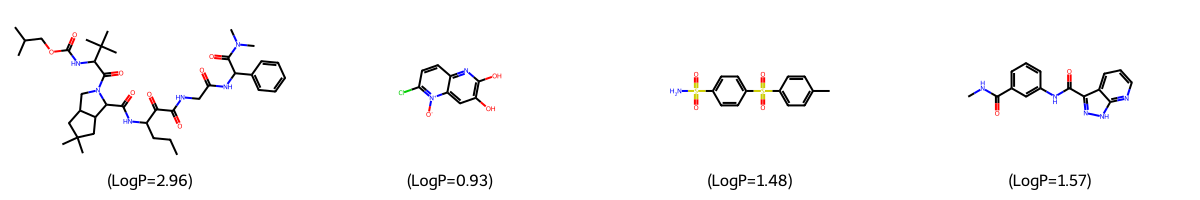

----------------------------------------------------------------------------------------------------
target_logp=4
Number of smiles (after filter): 992
#unique_valid-smiles:            992
#unique-valid_molecules:         991
#uniqueness-fraction:            0.999
----------------------------------------------------------------------------------------------------


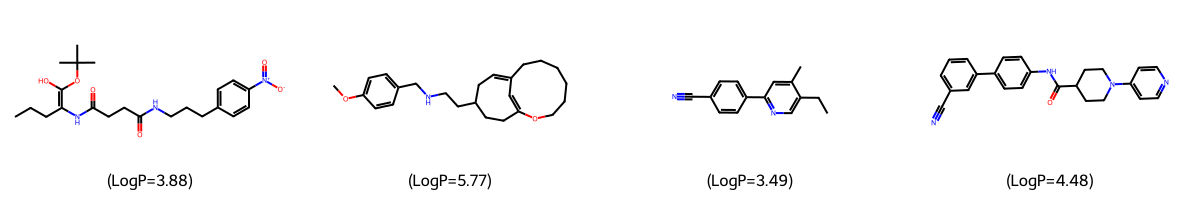

----------------------------------------------------------------------------------------------------
target_logp=6
Number of smiles (after filter): 980
#unique_valid-smiles:            980
#unique-valid_molecules:         980
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


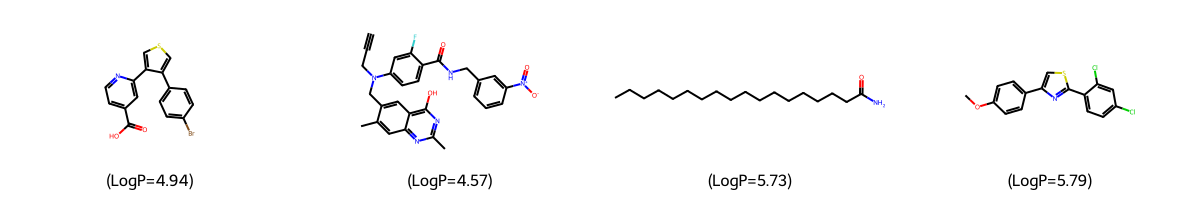

----------------------------------------------------------------------------------------------------
target_logp=8
Number of smiles (after filter): 921
#unique_valid-smiles:            921
#unique-valid_molecules:         921
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------


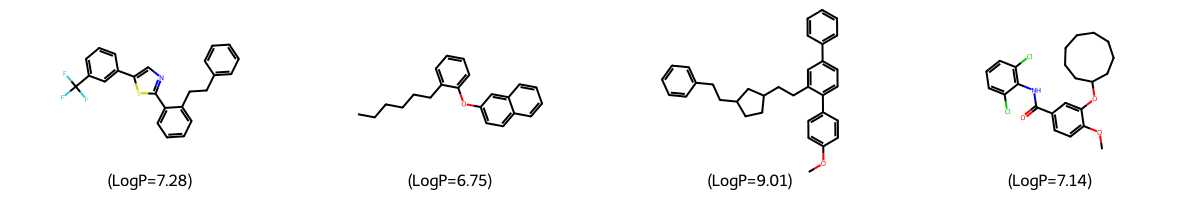

----------------------------------------------------------------------------------------------------
target_logp=10
Number of smiles (after filter): 827
#unique_valid-smiles:            827
#unique-valid_molecules:         826
#uniqueness-fraction:            0.999
----------------------------------------------------------------------------------------------------


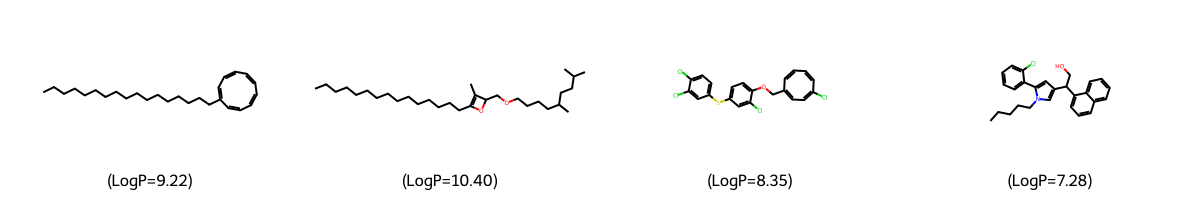

In [6]:
##############################################################################################################
### 2) Figure displaying property distribution for molecules generated for different target logp values
##############################################################################################################
# Define local plot specs
x_ticks_logp            = [-4, 0, 4, 8, 12]
y_max_scale_logp        = 3.5
bin_edges_logp          = np.linspace(-5, 13, 45)
panel_label_rel_xy_logp = [0.03, 0.97]
panel_label_rel_xy_ts   = [0.97, 0.97]
num_valid_samples_logp  = 1000
fs_dict  = {
    'axis':  28, #25,
    'ticks': 25, #22,
    'leg':   25, #22,
    'title': 30, #27,
    'text':  28, #25,
}
exact_or_tag        = 'exact' # Show 'exact' or 'tag'?
logp_list           = ['logp=-2', 'logp=0', 'logp=2', 'logp=4', 'logp=6', 'logp=8', 'logp=10']
panel_labels        = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's']
panel_counter_col0  = 0
panel_counter_col1  = 0
num_rows            = len(logp_list)

# Make the figure and with panels
fig, axs = plt.subplots(num_rows, 2, figsize=(4*2, len(logp_list)*4.5))

### Row 1, col 3/4: LogP
y_max_logp = 0
panel_label_handles_col0 = list()
panel_label_handles_col1 = list()
for index, key in enumerate(logp_list):
    # Update the key
    key = f"{key}_{exact_or_tag}"
    
    # Only show legend for first plot
    if index==0:
        show_legend=True
    else:
        show_legend=False
        
    ## Get the first column axis
    ax = axs[index, 0]

    # Get the panel label
    panel_label         = panel_labels[panel_counter_col0]
    panel_counter_col0 += 1

    # Get the target class
    target_logp = int(list(set(gen_df_dict[key]['target_logp']))[0])
    title_label = r'$\mathrm{LogP}^{\star}$='+str(target_logp)
    ax.set_title(title_label, fontsize=fs_dict['title'])

    # Get the property (here num-rings) distribution for the valid molecules
    distr_l = utils.get_property_distr(gen_df_dict['logp=None'], 'ground_truth', property_name='logp', num_valid_samples=num_valid_samples_logp)
    distr_r = utils.get_property_distr(gen_df_dict[key], 'ground_truth', property_name='logp', num_valid_samples=num_valid_samples_logp)

    # Make the plot
    y_max_logp_local, panel_label_handle = plotting.plot_logp_distr(distr_l,
                                                                    distr_r,
                                                                    bin_edges=bin_edges_logp,
                                                                    color_l=color_uc,
                                                                    color_r=color_cp,
                                                                    label_l=label_uc,
                                                                    label_r=label_cp,
                                                                    x_label=x_label_logp,
                                                                    x_ticks=x_ticks_logp,
                                                                    show_y_ticks=False,
                                                                    show_legend=show_legend,
                                                                    fs_dict=fs_dict,
                                                                    panel_label=panel_label,
                                                                    panel_label_rel_xy=panel_label_rel_xy_logp,
                                                                    panel_label_fontweight='bold',
                                                                    ax=ax,
                                                                    leg_loc='upper right',
                                                                    alpha=alpha,
                                                                    leg_framealpha=0.6,
                                                                    leg_handletextpad=0.1,
                                                                    leg_handlelength=1,
                                                                    leg_borderpad=0.1,
                                                                    leg_vertical_labelspacing=0.1)
    
    # Update y_max of logp-plots
    y_max_logp = max([y_max_logp, y_max_logp_local])

    # Append the panel label handle to corresponding list
    panel_label_handles_col0.append(panel_label_handle)

    ## Get the second column axis
    ax = axs[index, 1]

    # Get the panel label
    panel_label         = panel_labels[num_rows+panel_counter_col1]
    panel_counter_col1 += 1

    # Get the pairwise Tanimoto similarity (ts) distribution
    ts_distr_l = cheminf.get_tanimoto_similarities(gen_df_dict['logp=None']['nswcs'], which=which_ts, mfp_radius=mfp_radius, mfp_size=mfp_size)
    ts_distr_r = cheminf.get_tanimoto_similarities(gen_df_dict[key]['nswcs'], which=which_ts, mfp_radius=mfp_radius, mfp_size=mfp_size)
    print('*'*100)
    print(f"Mean Tanimoto similarity 'logp=None': {np.mean(ts_distr_l)}")
    print(f"Mean Tanimoto similarity {key}: {np.mean(ts_distr_r)}")
    print('*'*100)

    # Make the plot
    plotting.plot_tanimoto_similarity_distr(ts_distr_l,
                                            ts_distr_r, 
                                            bin_edges=bin_edges_ts,
                                            color_l=color_uc,
                                            color_r=color_cp,
                                            label_l=label_uc,
                                            label_r=label_cp,
                                            x_label=x_label_ts,
                                            x_ticks=x_ticks_ts,
                                            x_tick_labels=x_tick_labels_ts,
                                            show_y_ticks=False,
                                            show_legend=False,
                                            fs_dict=fs_dict,
                                            panel_label=panel_label,
                                            panel_label_rel_xy=panel_label_rel_xy_ts,
                                            panel_label_ha='right',
                                            panel_label_fontweight='bold',
                                            ax=ax,
                                            alpha=alpha)

# Determine y_max of the logp plots by scaling it
y_lim_logp = [0, y_max_logp*y_max_scale_logp]

# Set the y-limits for all log-p plots
for index in range(len(logp_list)):
    axs[index, 0].set_ylim(y_lim_logp)
    panel_label_y = y_lim_logp[0]+(y_lim_logp[1]-y_lim_logp[0])*panel_label_rel_xy_logp[1]
    panel_label_handles_col0[index].set_y(panel_label_y)

### Global specs
# Adjust subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.15, #0.08,
                    hspace=0.7) # 0.6 

plt.show()

# Save the figure as pdf
file_path = str(Path(figures_dir_path, 'appendix_logp_guidance.pdf'))
fig.savefig(file_path, format='pdf', bbox_inches='tight')


####################################################################################################
### Display the first 4 molecules generated for each specified target logp value
####################################################################################################
show_first = 4
property_name = 'logp'
property_label = 'LogP'
subImgSize = (300, 200)
for key in logp_list:
    # Update the key
    key = f"{key}_{exact_or_tag}"
    
    print('-'*100)
    filtered_df = utils.filter_unique_valid(gen_df_dict[key], show_first)
    nswcs_list = filtered_df['nswcs']
    img = cheminf.draw_molecule_grid(nswcs_list[:show_first], 
                                     property_name=property_name, 
                                     property_label=property_label, 
                                     molsPerRow=show_first, 
                                     subImgSize=subImgSize)
    display(img)


target_num_rings=0
Number of smiles (after filter): 918
#unique_valid-smiles:            918
#unique-valid_molecules:         916
#uniqueness-fraction:            0.998
----------------------------------------------------------------------------------------------------
target_num_rings=0
Number of smiles (after filter): 889
#unique_valid-smiles:            889
#unique-valid_molecules:         888
#uniqueness-fraction:            0.999
----------------------------------------------------------------------------------------------------
num_rings=0
U1: 404829.0
p:  0.6033691829390357
Significant difference: False
----------------------------------------------------------------------------------------------------
target_num_rings=1
Number of smiles (after filter): 989
#unique_valid-smiles:            989
#unique-valid_molecules:         989
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------
target_num_

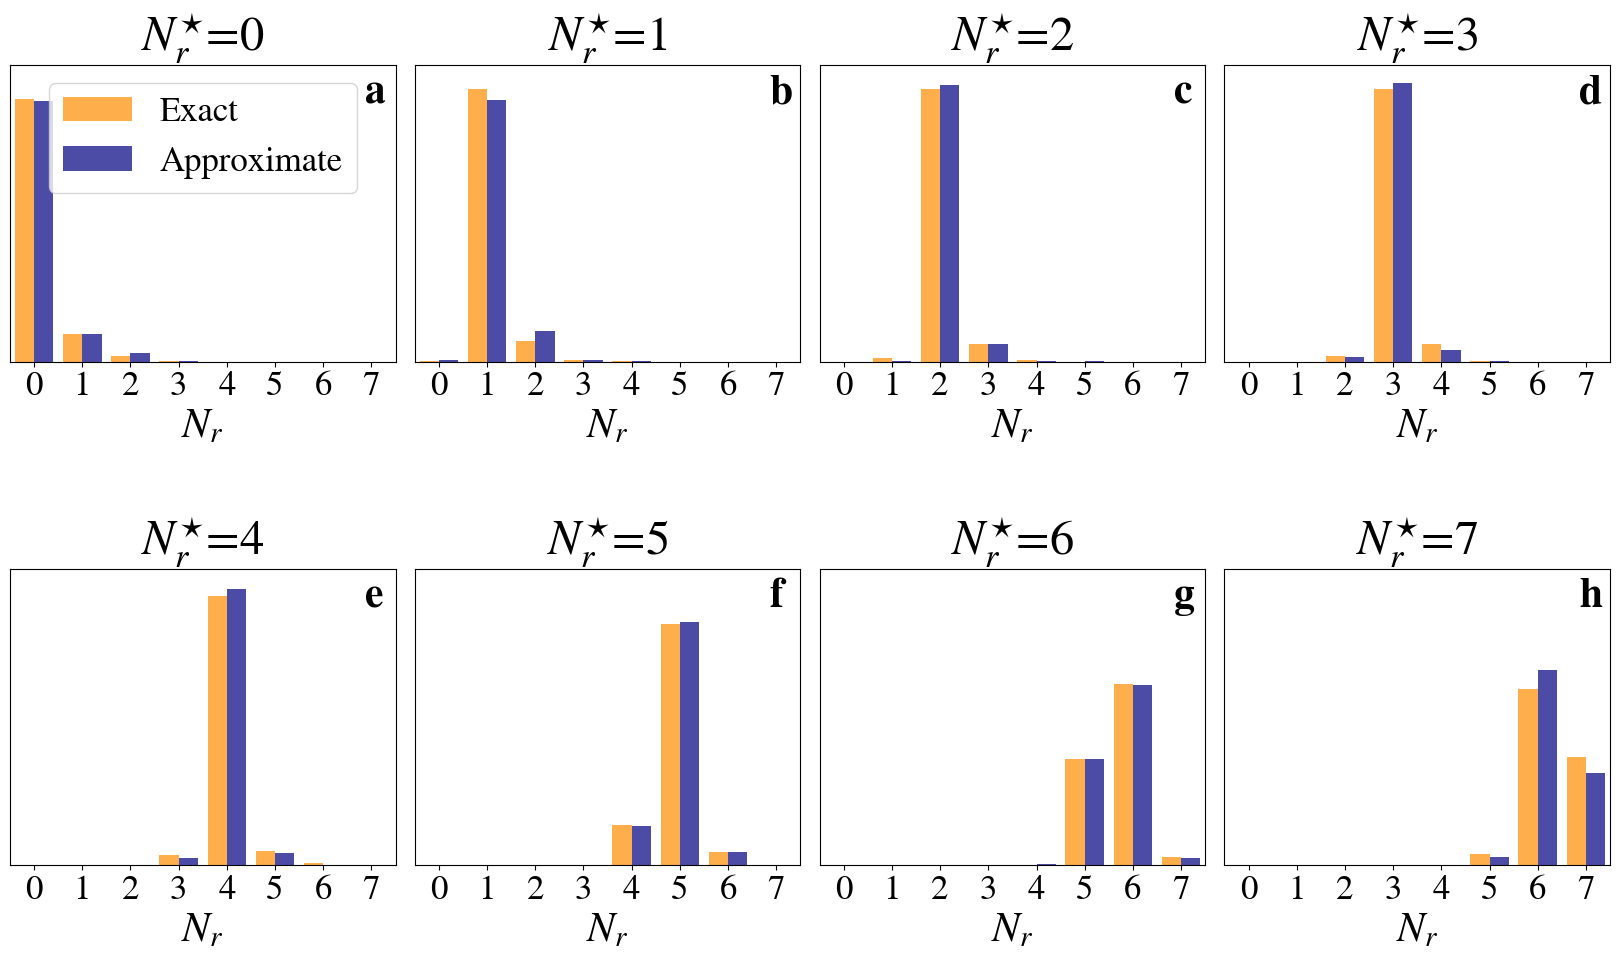

In [7]:
##############################################################################################################
### 3) Figure comparing exact vs. taylor-approximate guidance (tag) generation - Number of rings
##############################################################################################################
# Define local specs
bin_centers_num_rings       = np.linspace(0, 7, 8)
panel_label_rel_xy          = [0.92, 0.97]
num_valid_samples_num_rings = 1000
num_valid_samples_logp      = 1000
fs_dict  = {
    'axis':  30,
    'ticks': 25,
    'leg':   25,
    'title': 35,
    'text':  30,
}

num_rings_list = ['num_rings=0', 'num_rings=1', 'num_rings=2', 'num_rings=3', 'num_rings=4', 'num_rings=5', 'num_rings=6', 'num_rings=7']
panel_labels   = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's']
panel_counter  = 0

# Make the figure and with panels
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

### Row 1
for index, key in enumerate(num_rings_list):
    # Get the current axis (row index 0)
    col_ind = index%4
    row_ind = 0 if index<4 else 1
    ax = axs[row_ind, col_ind]
    if index==0:
        show_legend=True
    else:
        show_legend=False


    # Get the panel label
    panel_label    = panel_labels[panel_counter]
    panel_counter += 1

    # Get the current target class
    target_num_rings = int(list(set(gen_df_dict[f"{key}_exact"]['target_num_rings']))[0])

    # Set a title
    title_label = r'$N_{r}^{\star}$='+str(target_num_rings)
    ax.set_title(title_label, fontsize=fs_dict['title'])

    # Get the property (here num-rings) distribution for the valid molecules
    # Left bars are exact and right bars are approximative (TAG)
    distr_l = utils.get_property_distr(gen_df_dict[f"{key}_exact"], 'ground_truth', property_name='num_rings', num_valid_samples=num_valid_samples_num_rings)
    distr_r = utils.get_property_distr(gen_df_dict[f"{key}_TAG"], 'ground_truth', property_name='num_rings', num_valid_samples=num_valid_samples_num_rings)

    # Make the plot
    plotting.plot_num_rings_distr(distr_l,
                                  distr_r, 
                                  bin_centers=bin_centers_num_rings,
                                  color_l=color_ce,
                                  color_r=color_ca,
                                  label_l=label_ce,
                                  label_r=label_ca,
                                  x_label=x_label_num_rings,
                                  show_y_ticks=False,
                                  show_legend=show_legend,
                                  fs_dict=fs_dict,
                                  panel_label=panel_label,
                                  panel_label_rel_xy=panel_label_rel_xy,
                                  panel_label_fontweight='bold',
                                  ax=ax,
                                  leg_loc='upper center',
                                  alpha=alpha)
    
    # Do a two-sided Mann-Whitney-U test
    # Remark: We need method='asymptotic' because we have ties
    U1, p = scipy.stats.mannwhitneyu(distr_l, distr_r, use_continuity=False, alternative='two-sided', method='asymptotic')
    print(key)
    print(f"U1: {U1}")
    print(f"p:  {p}")
    print(f"Significant difference: {p<0.05}")
    print('-'*100)

### Global specs
# Adjust subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.7)

plt.show()

# Save the figure as pdf
file_path = str(Path(figures_dir_path, 'appendix_exact_vs_approximate_num_rings.pdf'))
fig.savefig(file_path, format='pdf', bbox_inches='tight')

target_logp=-2
Number of smiles (after filter): 816
#unique_valid-smiles:            816
#unique-valid_molecules:         814
#uniqueness-fraction:            0.998
----------------------------------------------------------------------------------------------------
target_logp=-2
Number of smiles (after filter): 675
#unique_valid-smiles:            675
#unique-valid_molecules:         673
#uniqueness-fraction:            0.997
----------------------------------------------------------------------------------------------------
logp=-2
U1: 278779.0
p:  0.6830409430270517
Significant difference: False
----------------------------------------------------------------------------------------------------
target_logp=0
Number of smiles (after filter): 956
#unique_valid-smiles:            956
#unique-valid_molecules:         956
#uniqueness-fraction:            1.000
----------------------------------------------------------------------------------------------------
target_logp=0
Number of smil

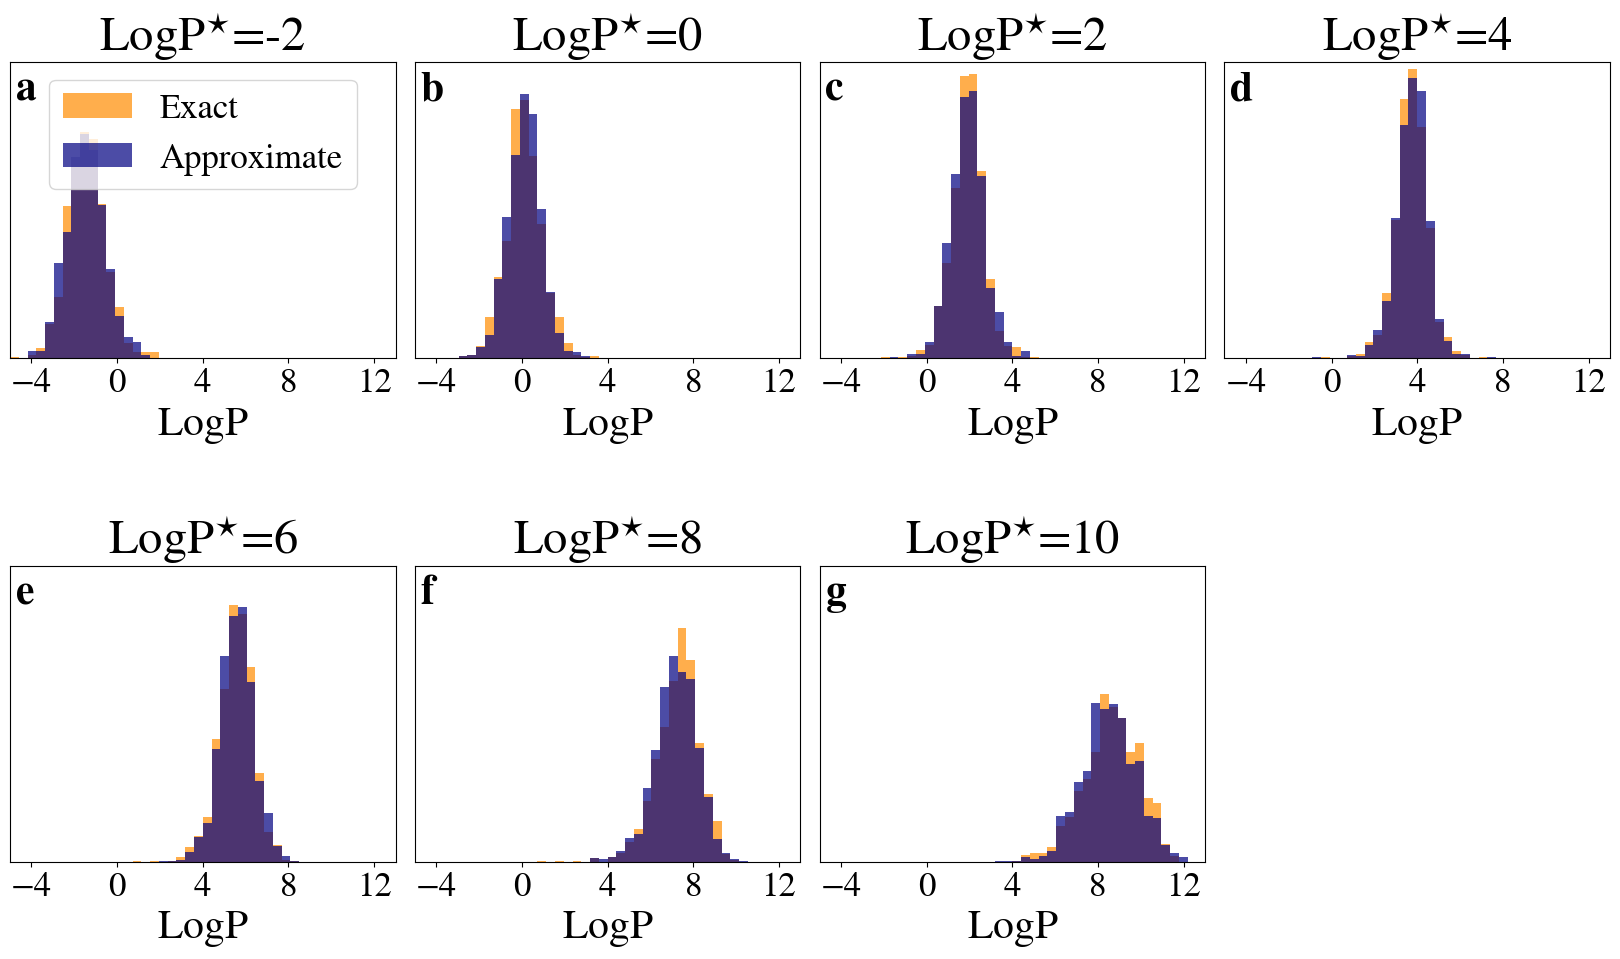

In [8]:
##############################################################################################################
### 4) Figure comparing exact vs. taylor-approximate guidance (tag) generation - LogP
##############################################################################################################
# Define local specs
bin_edges_logp              = np.linspace(-5, 13, 45)
panel_label_rel_xy          = [0.015, 0.97]
y_max_scale_logp            = 2.5
num_valid_samples_num_rings = 1000
num_valid_samples_logp      = 1000
fs_dict  = {
    'axis':  30,
    'ticks': 25,
    'leg':   25,
    'title': 35,
    'text':  30,
}

logp_list      = ['logp=-2', 'logp=0', 'logp=2', 'logp=4', 'logp=6', 'logp=8', 'logp=10']
panel_labels   = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
panel_counter  = 0

# Make the figure and with panels
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

### Row 1
y_max_logp = 0
panel_label_handles = list()
for index, key in enumerate(logp_list):
    # Get the current axis (row index 0)
    col_ind = index%4
    row_ind = 0 if index<4 else 1
    ax = axs[row_ind, col_ind]
    if index==0:
        show_legend=True
    else:
        show_legend=False


    # Get the panel label
    panel_label    = panel_labels[panel_counter]
    panel_counter += 1

    # Get the current target class
    target_logp = int(list(set(gen_df_dict[f"{key}_exact"]['target_logp']))[0])

    # Set a title
    title_label = r'$\mathrm{LogP}^{\star}$='+str(target_logp)
    ax.set_title(title_label, fontsize=fs_dict['title'])

    # Get the property (here num-rings) distribution for the valid molecules
    # Left bars are exact and right bars are approximative (TAG)
    distr_l = utils.get_property_distr(gen_df_dict[f"{key}_exact"], 'ground_truth', property_name='logp', num_valid_samples=num_valid_samples_num_rings)
    distr_r = utils.get_property_distr(gen_df_dict[f"{key}_TAG"], 'ground_truth', property_name='logp', num_valid_samples=num_valid_samples_num_rings)

    # Make the plot
    y_max_logp_local, panel_label_handle = plotting.plot_logp_distr(distr_l,
                                                                    distr_r, 
                                                                    bin_edges=bin_edges_logp,
                                                                    color_l=color_ce,
                                                                    color_r=color_ca,
                                                                    label_l=label_ce,
                                                                    label_r=label_ca,
                                                                    x_label=x_label_logp,
                                                                    x_ticks=x_ticks_logp,
                                                                    show_y_ticks=False,
                                                                    show_legend=show_legend,
                                                                    fs_dict=fs_dict,
                                                                    panel_label=panel_label,
                                                                    panel_label_rel_xy=panel_label_rel_xy,
                                                                    panel_label_fontweight='bold',
                                                                    ax=ax,
                                                                    leg_loc='upper center',
                                                                    alpha=alpha)
    
    # Update y_max of logp-plots
    y_max_logp = max([y_max_logp, y_max_logp_local])

    # Append the panel label handle to corresponding list
    panel_label_handles.append(panel_label_handle)
    
    # Do a two-sided Mann-Whitney-U test
    # Remark: We need method='asymptotic' because we have ties
    U1, p = scipy.stats.mannwhitneyu(distr_l, distr_r, use_continuity=False, alternative='two-sided', method='asymptotic')
    print(key)
    print(f"U1: {U1}")
    print(f"p:  {p}")
    print(f"Significant difference: {p<0.05}")
    print('-'*100)

# Determine y_max of the logp plots by scaling it
y_lim_logp = [0, y_max_logp*y_max_scale_logp]

# Set the y-limits for all log-p plots
for index in range(len(logp_list)):
    # Get the current axis (row index 0)
    col_ind = index%4
    row_ind = 0 if index<4 else 1
    ax = axs[row_ind, col_ind].set_ylim(y_lim_logp)
    panel_label_y = y_lim_logp[0]+(y_lim_logp[1]-y_lim_logp[0])*panel_label_rel_xy[1]
    panel_label_handles[index].set_y(panel_label_y)

# Switch lower-left corner subplot off
axs[-1, -1].axis('off')

### Global specs
# Adjust subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.7)

plt.show()

# Save the figure as pdf
file_path = str(Path(figures_dir_path, 'appendix_exact_vs_approximate_logp.pdf'))
fig.savefig(file_path, format='pdf', bbox_inches='tight')

dict_keys(['num_rings=None', 'num_rings=0_exact', 'num_rings=1_exact', 'num_rings=2_exact', 'num_rings=3_exact', 'num_rings=4_exact', 'num_rings=5_exact', 'num_rings=6_exact', 'num_rings=7_exact', 'num_rings=0_TAG', 'num_rings=1_TAG', 'num_rings=2_TAG', 'num_rings=3_TAG', 'num_rings=4_TAG', 'num_rings=5_TAG', 'num_rings=6_TAG', 'num_rings=7_TAG', 'logp=None', 'logp=-2_exact', 'logp=0_exact', 'logp=2_exact', 'logp=4_exact', 'logp=6_exact', 'logp=8_exact', 'logp=10_exact', 'logp=-2_TAG', 'logp=0_TAG', 'logp=2_TAG', 'logp=4_TAG', 'logp=6_TAG', 'logp=8_TAG', 'logp=10_TAG'])


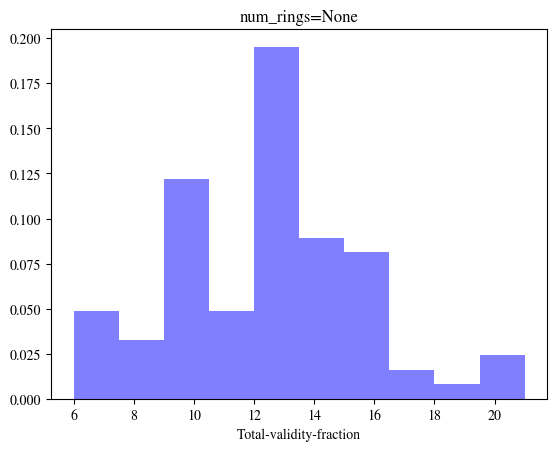

num_rings=None
total-validity-fraction = 12.231707317073171+-3.1402143024889586

----------------------------------------------------------------------------------------------------


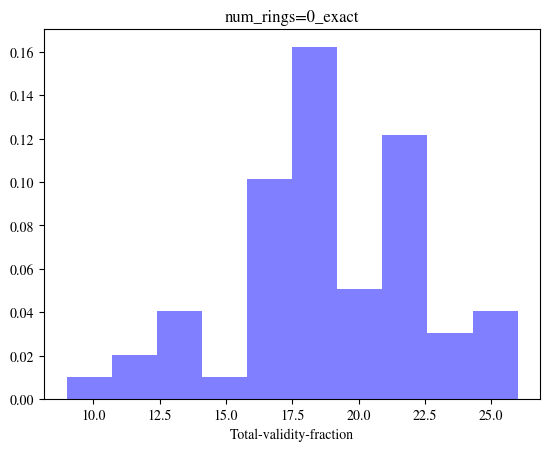

num_rings=0_exact
total-validity-fraction = 18.862068965517242+-3.491113229537343

----------------------------------------------------------------------------------------------------


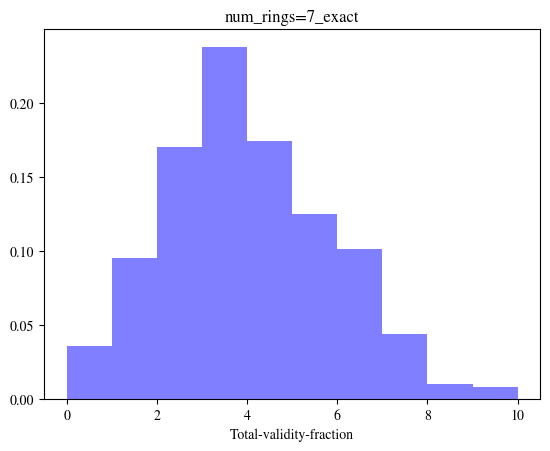

num_rings=7_exact
total-validity-fraction = 3.5346534653465347+-1.8570942726042414

----------------------------------------------------------------------------------------------------


In [9]:
# Define the name of the samples table files
logfile_name = 'logs'

# Load all the logfiles found in the run folders
logfile_dict = dict()
for key, rel_dir_path in rel_dir_path_dict.items():
    file_path = str(Path(generated_dir, rel_dir_path, logfile_name))
    with open(file_path, 'r') as file:
        logfile_content = file.read()
        logfile_dict[key] = logfile_content

print(logfile_dict.keys())

# Define the search pattern for the total validity fraction within the log files
pattern = r'Validity fraction \(total\):\s*?([\d:,.]+)%'

# Find all occurences of the pattern and cast the obtained total validity
# fractions values from string to floats
for key in ['num_rings=None' , 'num_rings=0_exact', 'num_rings=7_exact']:
    findall = re.findall(pattern, logfile_dict[key])
    total_validity_fractions = [float(item) for item in findall]

    # Plot the total validity fraction distribution
    plt.figure()
    plt.title(key)
    plt.hist(total_validity_fractions, density=True, color='b', alpha=0.5, histtype='stepfilled')
    plt.xlabel('Total-validity-fraction')
    plt.show()

    # Display stas
    mean_tvf = np.mean(total_validity_fractions)
    std_tvf  = np.std(total_validity_fractions)
    print(key)
    print(f"total-validity-fraction = {mean_tvf}+-{std_tvf}")
    print()
    print('-'*100)
